# Bangladesh Multimodal Freight Transport Network Criticality Analysis - Examples
Bramka Arga Jafino

Delft University of Technology

Faculty of Technology, Policy and Management

## An introduction note

This notebook provides an example of cradle-to-grave implementation of Bangladesh transport network criticality. Therefore, not all metrics are calculated in this notebook. Rather, only examples of several metrics are presented.

## 1. Import all required modules

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
import geopandas as gp
from __future__ import division

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Modules developed for this project
from transport_network_modeling import network_prep as net_p
from transport_network_modeling import network_visualization as net_v
from transport_network_modeling import od_prep as od_p
from transport_network_modeling import criticality as betw_w

## 2. Network Preparation

Prepare GeoDataFrame of (i) all points in the road network, (ii) location of all centroids, (iii) all roads in the road network 

In [2]:
network = r'./model_input_data/rmms_v11_7_waterway_noZ2.shp'
centroid = r'./model_input_data/BGD_Districtdata_Citycentroid_level2_v03.shp'

gdf_points, gdf_node_pos, gdf = net_p.prepare_centroids_network(centroid, network)

Reduce the cost to go through waterway

In [3]:
cost_reduction = 0.05
gdf['length'] = gdf.apply(lambda row: (row['length'] * (1 - cost_reduction) if row['mode']=='water' else row['length']), axis=1)

Apply transshipment cost to shift mode from/to waterway

In [4]:
# gdf['penalty'] = gdf.apply(lambda row: 15 if (row['cross']==1 and row['mode']=='road') else 0, axis=1)
# gdf['length'] = gdf['length'] + gdf['penalty']

Create Networkx MultiGraph object from the GeoDataFrame

In [5]:
G2_new = net_p.gdf_to_simplified_multidigraph(gdf_node_pos, gdf)

Change the MultiGraph object to Graph object to reduce computation cost 

In [6]:
G2_new_tograph = net_p.multigraph_to_graph(G2_new)

Observe the properties of the Graph object

In [7]:
print('number of disconnected compoents is', nx.number_connected_components(G2_new_tograph))
nx.info(G2_new_tograph)

('number of disconnected compoents is', 3)


'Name: \nType: Graph\nNumber of nodes: 966\nNumber of edges: 1260\nAverage degree:   2.6087'

Take only the largest subgraph

In [8]:
#take the largest components
for g in nx.connected_component_subgraphs(G2_new_tograph):
    if len(list(g.edges())) > 100:
        G3 = g
        
G2_new_tograph = G3.copy()

Save the simplified transport network back into GeoDataFrame

In [9]:
gdf2 = net_p.graph_to_df(G2_new_tograph)

Prepare the districts statistics

In [10]:
adm_csv = r'./model_input_data/District_level_data_v7.csv'
adm_shp = r'./model_input_data/BGD_adm2.shp'
#Save the following information from csv to DataFrame
district_gdf2 = net_p.prepare_adm_background(adm_csv, adm_shp, ['Code', 'Population', 'Population_M', 'Total_export',
                                                               'Jute_mill', 'Flour_mill', 'Tot_Garment_Factory', 'Household',
                                                               'Land_throughput', 'SteelBricks_exp_ton', 'Food_exp_ton',
                                                               'Jutextile_exp_ton', 'Garment_exp_ton', 'Textile_loc_ton',
                                                               'Wheat_loc_ton', 'RawJute_loc_ton', 'Foods_loc_ton',
                                                               'Nonfoods_loc_ton'])

C:\Users\Lenovo\Anaconda2\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Embed the district data to centroids GeoDataFrame 

In [11]:
#read district data
district_data = pd.read_csv(adm_csv)

#rename to HASC_2
district_data.rename(columns={'Code':'HASC_2'}, inplace=True)

#merge them
gdf_points = pd.merge(gdf_points,district_data,on='HASC_2',how='outer')

Ensure that both dataframe have same crs

In [12]:
district_gdf2.crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}
gdf2.crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}

## 3. Origin-Demand (OD) Matrix Preparation

Extract the Node ID of all centroid nodes

In [13]:
centroid_nodes = od_p.prepare_centroids_list(G2_new_tograph)

Prepare export-based OD

In [14]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Total_export'

#create the OD dictionary
OD_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

OD_export = OD_export_dict[OD_export_dict.keys()[0]]
for i in range(len(OD_export_dict)-1):
    OD_export = OD_export +  OD_export_dict[OD_export_dict.keys()[i+1]]

Prepare land ports export-based OD

In [15]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Land_throughput'

#create the OD dictionary
OD_land_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

OD_land_export = OD_land_export_dict[OD_land_export_dict.keys()[0]]
for i in range(len(OD_land_export_dict)-1):
    OD_land_export = OD_land_export +  OD_land_export_dict[OD_land_export_dict.keys()[i+1]]

Prepare local transaction OD

In [16]:
#local trade OD    
    
#first for products which attraction is population
prod_lists = ['Garment_loc_ton', 'Steel_loc_ton','Jute_loc_ton',
              'Rice_loc_ton', 'Fruits_loc_ton', 'Potatoes_loc_ton', 'Sugar_loc_ton']
attr_driver='Population_x'
OD_local_dict1 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#next for raw jute
prod_lists = ['RawJute_loc_ton']
attr_driver='Jute_mill'
OD_local_dict2 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#next for wheat
prod_lists = ['Wheat_loc_ton']
attr_driver='Flour_mill'
OD_local_dict3 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#next for textile
prod_lists = ['Textile_loc_ton']
attr_driver='Tot_Garment_Factory'
OD_local_dict4 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#last for bricks
prod_lists = ['Bricks_loc_ton']
attr_driver='Household'
OD_local_dict5 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

Combine all OD dictionaries into final OD Matrix

In [17]:
#Combine all local OD
OD_local1 = OD_local_dict1[OD_local_dict1.keys()[0]]
for i in range(len(OD_local_dict1)-1):
    OD_local1 = OD_local1 +  OD_local_dict1[OD_local_dict1.keys()[i+1]]
    
OD_local2 = OD_local_dict2[OD_local_dict2.keys()[0]]

OD_local3 = OD_local_dict3[OD_local_dict3.keys()[0]]

OD_local4 = OD_local_dict4[OD_local_dict4.keys()[0]]

OD_local5 = OD_local_dict5[OD_local_dict5.keys()[0]]

OD_local_all= OD_local1 + OD_local2 + OD_local3 + OD_local4 + OD_local5

In [18]:
#Create OD_all
OD_all = OD_local_all + OD_export

Create unweighted OD matrix for unweighted betweenness criticality analysis

In [19]:
centroid_district_listed = list(OD_all.columns)

OD_unweighted = pd.DataFrame(1, index=centroid_district_listed, columns=centroid_district_listed)

for i,row in OD_unweighted.iterrows():
    OD_unweighted.loc[i][i] = 0

Observe the OD Matrix in a graph

OD Heatmap for Division level


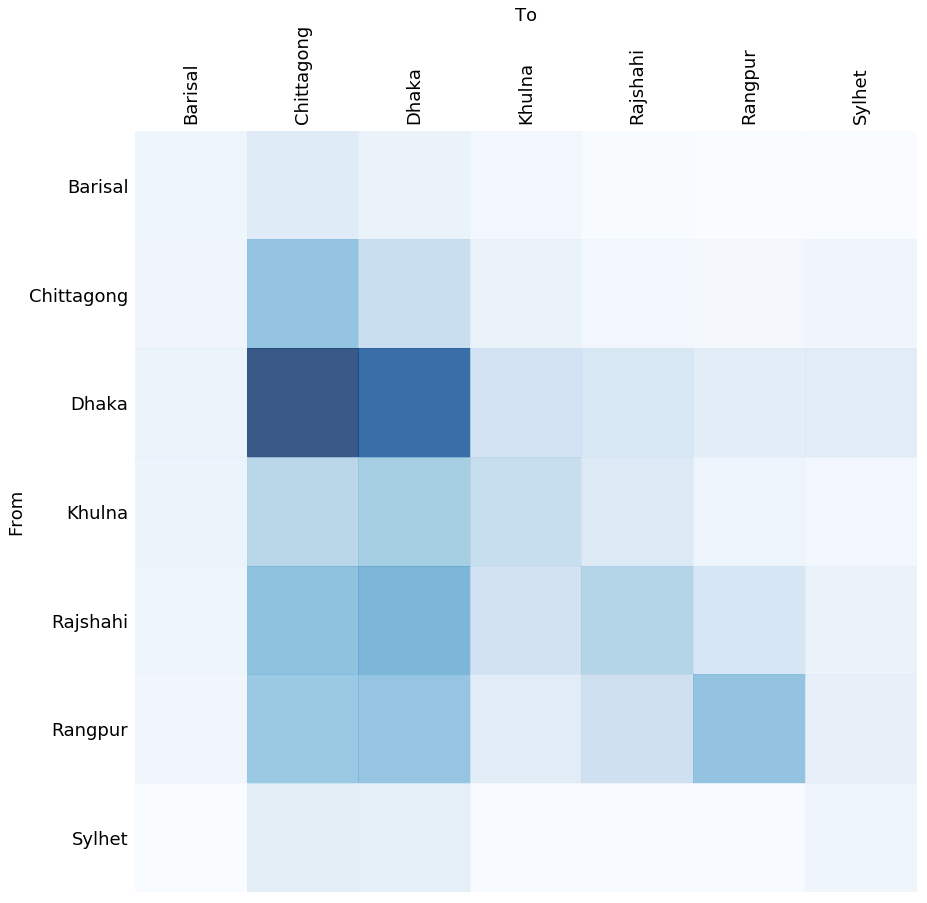

In [20]:
print('OD Heatmap for Division level')
net_v.plot_od_heatmap(OD_df = OD_all, gdf_points = gdf_points, division=True)

OD Heatmap for District level


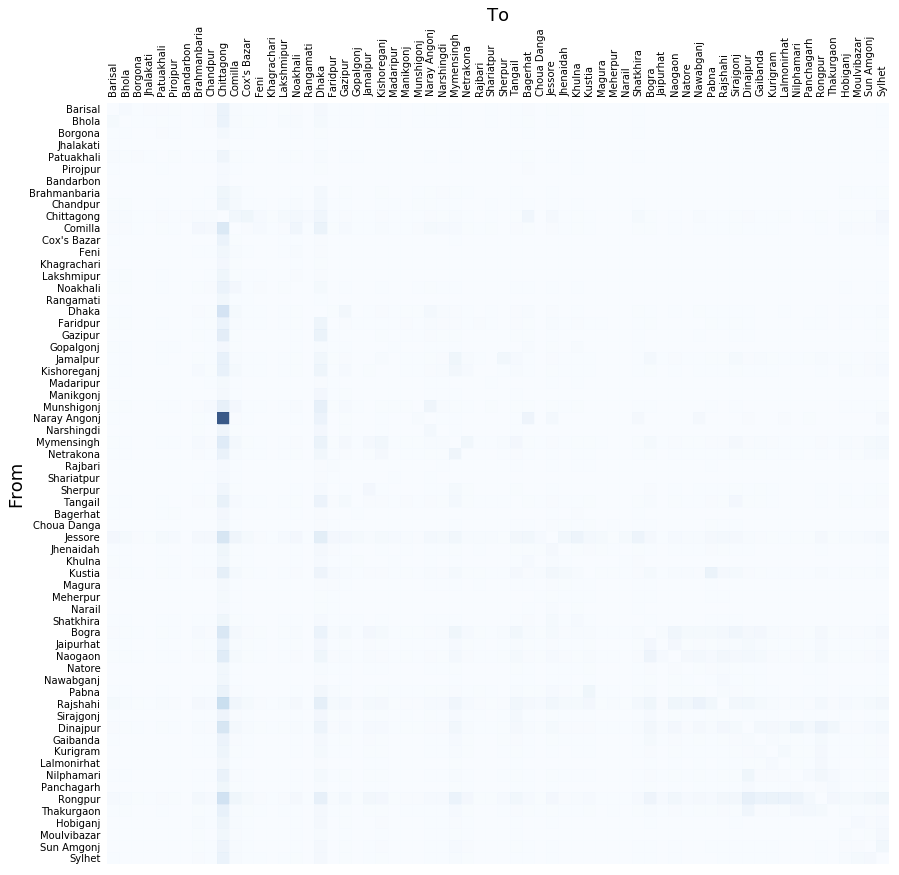

In [21]:
print('OD Heatmap for District level')
net_v.plot_od_heatmap(OD_df = OD_all, gdf_points = gdf_points)

OD Heatmap for District level, only for local market transportation activities


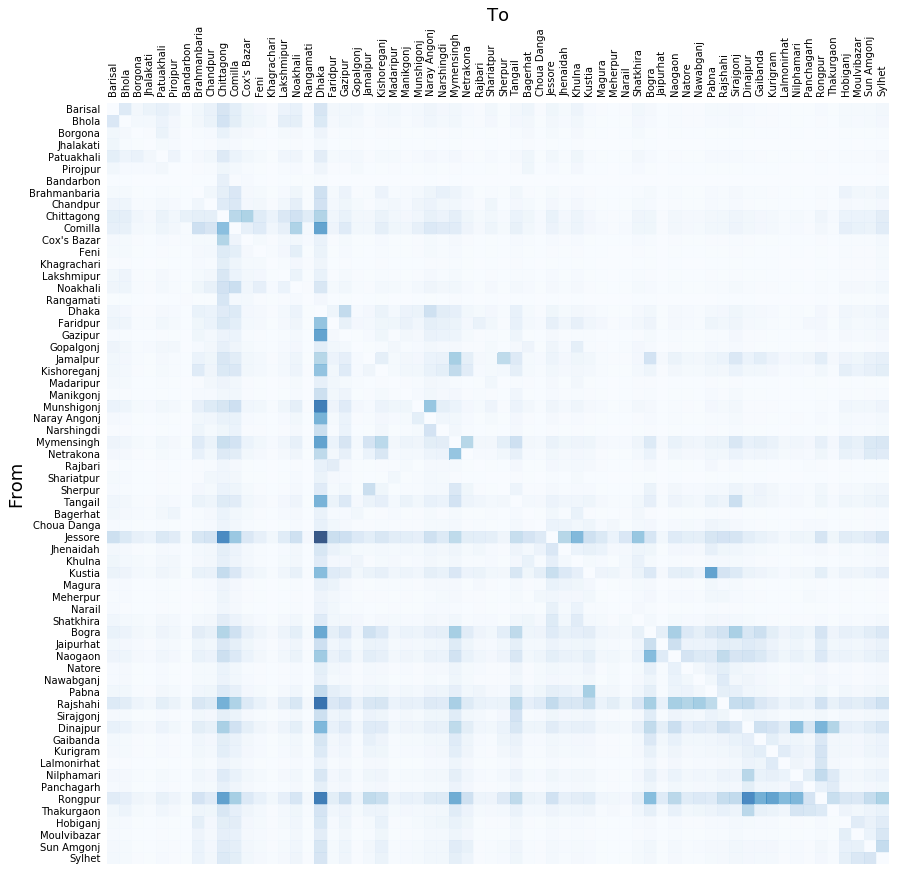

In [22]:
print('OD Heatmap for District level, only for local market transportation activities')
net_v.plot_od_heatmap(OD_df = OD_local_all, gdf_points = gdf_points)

## 4. Criticality analysis
Three criticality metrics are computed in this part:
1. Weighted betweenness criticality (M8_02 in the thesis report)
2. Unweighted betweenness criticality (M3_01 in the thesis report)
3. Minimum link cut criticality (M4_01 in the thesis report)

As in the visualization, the red links represent Bangladesh's road network while the blue links represent Bangladesh's waterway network.

### 4.1 Weighted betweenness criticality (M8_02)

In [23]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_all, N=5, penalty=1.1)

betweenness_all_probit = betw_w.edge_betweenness_centrality(flow_probit_5, OD_all)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf2,betweenness_all_probit,'betweenness_all_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_all_probit.values()))
print(e-c)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,flow_probit_5,'flow_probit_5')

15904991.0314
0.263853497363
0:05:38.487000


In [24]:
total_water = gdf_final.loc[gdf_final['mode']=='water']['flow_probit_5'].sum()
total_road = gdf_final.loc[gdf_final['mode']=='road']['flow_probit_5'].sum()
total_flow = total_water + total_road
perc_water = 100 * total_water / total_flow
perc_road = 100 * total_road / total_flow
print('percentage by road is {} percent'.format(perc_road))
print('percentage by water is {} percent'.format(perc_water))

percentage by road is 88.301012929 percent
percentage by water is 11.698987071 percent


Weighted link betweenness centrality (metric M8_02 in the main report)


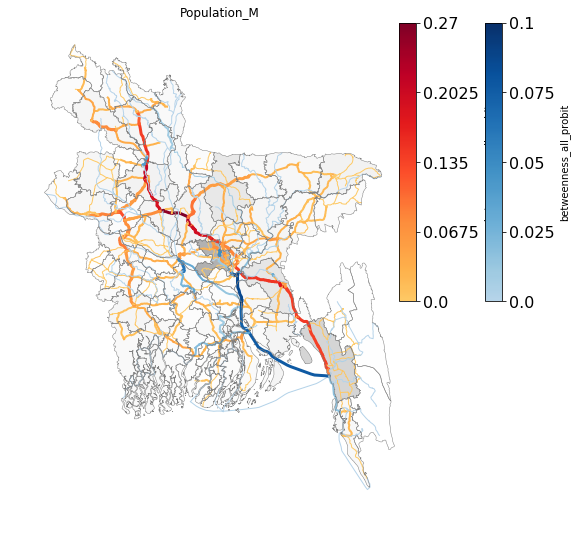

In [28]:
#create special colormap
cmap = plt.get_cmap('YlOrRd')
new_cmap1 = net_v.truncate_colormap(cmap, 0.3, 1)
cmap = plt.get_cmap('Blues')
new_cmap2 = net_v.truncate_colormap(cmap, 0.3, 1)

print('Weighted link betweenness centrality (metric M8_02 in the main report)')
net_v.plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_all_probit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.27, 0.1],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

### 4.2 Unweighted betweenness criticality (M3_01)

In [29]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = betw_w.aon_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_unweighted)

betweenness_unweighted = betw_w.edge_betweenness_centrality(flow_probit_5, OD_unweighted)

gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,betweenness_unweighted,'betweenness_unweighted')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_unweighted.values()))
print(e-c)

1154
0.28621031746
0:00:35.057000


In [31]:
gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,flow_probit_5,'flow_probit_5')

In [34]:
total_water = gdf_final.loc[gdf_final['mode']=='water']['flow_probit_5_y'].sum()
total_road = gdf_final.loc[gdf_final['mode']=='road']['flow_probit_5_y'].sum()
total_flow = total_water + total_road
perc_water = 100 * total_water / total_flow
perc_road = 100 * total_road / total_flow
print('percentage by road is {} percent'.format(perc_road))
print('percentage by water is {} percent'.format(perc_water))

percentage by road is 89.3858533733 percent
percentage by water is 10.6141466267 percent


Unweighted edge betweenness centrality (metric M3_01 in the main report)


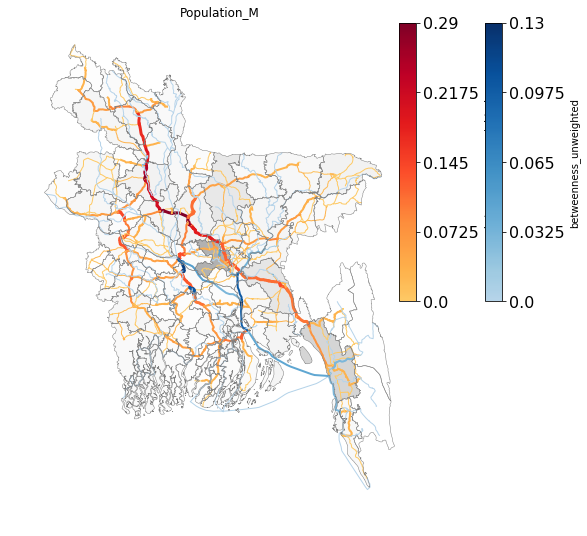

In [37]:
print('Unweighted edge betweenness centrality (metric M3_01 in the main report)')
net_v.plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_unweighted', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.29, 0.13],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

### 4.3 Minimum link cut criticality (M4_01)

In [39]:
edgecut_dict = betw_w.min_edge_cut(G=G2_new_tograph, centroid_nodes=centroid_nodes)

In [41]:
gdf_final, betweenness_df = betw_w.betweenness_to_df(gdf_final,edgecut_dict,'Min_EdgeCut_Criticality')

In [87]:
import numpy as np
def _get_percentile(gdf2, col, n):
    #get n-th percentile of a DataFrame column
    get_col = list(gdf2[col])
    get_col = [x for x in get_col if x > 0]
    nth_percentile = np.percentile(get_col, n)

    return nth_percentile

Minimum edge cut criticality (metric M4_01 in the main report)


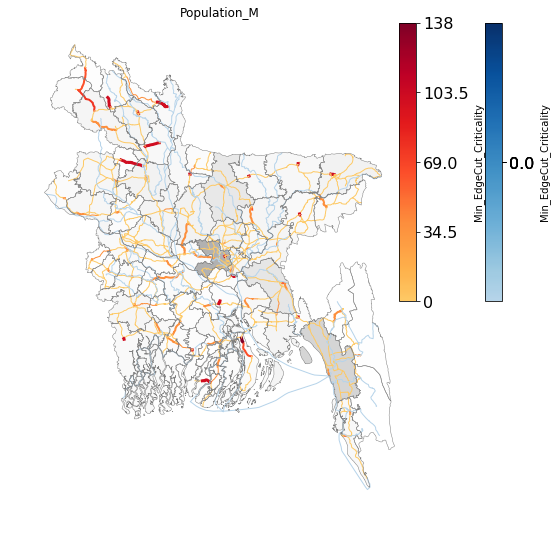

In [89]:
print('Minimum edge cut criticality (metric M4_01 in the main report)')
plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='Min_EdgeCut_Criticality', 
                        cmaps=[new_cmap1, new_cmap2],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])